# Projeto Integrado Final - Deep Learning

Desenvolvimento de modelo classificação utilizando Redes Neurais Convolucionais (CNN) ou Redes Neurais Recorrentes (RNN), com base na tendencia de mercado dos ultimos 15 dias, considerando o "close" da ação em base de dados suavizada. 

!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow
!pip install distutils

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from collections import defaultdict

In [6]:
df_train = pd.read_csv('../src/data/BBAS3.SA/treino.csv')
df_test = pd.read_csv('../src/data/BBAS3.SA/teste.csv')

## Exploratory Data Analysis

In [ ]:
df_train.head(2)

In [ ]:
df_test.head(2)

In [ ]:
nome_arquivo = 'BBAS3'
# EDA
print(f"EDA para {nome_arquivo}:")
print(f"Descrição dos dados:\n{df_train.describe()}\n")
print(f"Contagem de valores NaN por coluna:\n{df_train.isna().sum()}\n")
print(f"Contagem dos rótulos:\n{df_train['Label'].value_counts()}\n")


In [ ]:
# COMPARAÇÃO ENTRE PREÇOS DE FECHAMENTO E PREÇOS DE FECHAMENTO SUAVIZADOS
plt.figure(figsize=(14, 7))
plt.plot(df_train['Close'], label='Close')
plt.plot(df_train['Smoothed_Close'], label='Smoothed Close')
plt.title(f'Preços de Fechamento e Suavizados - {nome_arquivo}')
plt.legend()
plt.show()

In [ ]:
# DISTRIBUIÇÃO DOS RÓTULOS
sns.countplot(x='Label', data=df_train)
plt.title(f'Distribuição de Classes - {nome_arquivo}')
plt.show()

## Treinamento de modelo de Redes Neurais Recorrentes (RNN)

In [ ]:
## NORMALIZAÇÃO DOS DADOS

# Normalizador para as features
scaler = StandardScaler()

# Função para converter rótulos em formato categórico
def converter_para_categorico(y):
    if y.min() == -1:  # Se os rótulos forem -1 e 1
        y = (y + 1) // 2  # Converter rótulos para 0 e 1
    return to_categorical(y)

X_train = df_train.drop(['Date', 'Close', 'Smoothed_Close', 'Label'], axis=1)
y_train = df_train['Label']

X_test = df_test.drop(['Date', 'Close', 'Smoothed_Close', 'Label'], axis=1)
y_test = df_test['Label']

# Normalizar as features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Converter os rótulos para formato categórico
y_train_cat = converter_para_categorico(y_train)
y_test_cat = converter_para_categorico(y_test)

In [ ]:
# Cria e treina a rede LSTM
historicos = {}

model_rnn = Sequential([
        LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False, activation='relu'),
        Dense(y_train_cat.shape[1], activation='sigmoid')
    ])

# Compilando o modelo com entropia cruzada categórica para classificação binária
# A acurácia é usada como métrica para avaliação
model_rnn.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o modelo com os dados
# Epochs define o número de vezes que o modelo verá todo o conjunto de dados
# Batch size é o número de amostras que o modelo vê antes de atualizar os pesos
# Verbose=1 mostra a barra de progresso do treinamento

checkpointer = ModelCheckpoint(filepath='../models/melhor_rnn_BBAS3.keras', verbose=1,  save_best_only=True, monitor='val_accuracy')

historico_rnn = model_rnn.fit(X_train, y_train_cat, epochs=100, batch_size=8, validation_split=0.2, verbose=1, callbacks=[checkpointer],shuffle=True)


In [ ]:
def plotar_historico(historico, titulo):
    plt.figure(figsize=(12, 5))
    plt.plot(historico.history['accuracy'], label='Acurácia de Treino')
    if 'val_accuracy' in historico.history:
        plt.plot(historico.history['val_accuracy'], label='Acurácia de Validação')
    plt.plot(historico.history['loss'], label='LOSS de Treino')
    if 'val_loss' in historico.history:
        plt.plot(historico.history['val_loss'], label='LOSS de Validação')
    plt.title(titulo)
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia / Perda')
    plt.legend()
    plt.show()

plotar_historico(historico_rnn, f"Histórico de Treinamento - {nome_arquivo}")

In [ ]:
plot_model(model_rnn,show_shapes=True, show_layer_names=True)

In [ ]:
# Função para plotar a matriz de confusão
def plotar_matriz_confusao(cm, classes, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

# Avaliar o modelo
scores = model_rnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"{nome_arquivo} -> Acurácia: {scores[1]*100:.2f}%")

# Predições
y_pred = model_rnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_teste_classes = np.argmax(y_test_cat, axis=1)

# Gerar e plotar a matriz de confusão
cm = confusion_matrix(y_teste_classes, y_pred_classes)
plotar_matriz_confusao(cm, classes=['Classe 0', 'Classe 1'], title=f'Matriz de Confusão para {nome_arquivo}')

# Gerar relatório de classificação
print(f"Relatório de Classificação para {nome_arquivo}:\n {classification_report(y_teste_classes, y_pred_classes)}\n")

## Treinamento de Redes Neurais Convolucionais (CNN)

In [14]:
from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from keras.utils import plot_model
from keras.utils import  to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import Input
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image

In [8]:
url_train_img_c = '../src/data/BBAS3.SA/imagens/treino/comprar'
url_train_img_v = '../src/data/BBAS3.SA/imagens/treino/vender'
url_test_img_c = '../src/data/BBAS3.SA/imagens/teste/comprar'
url_test_img_v = '../src/data/BBAS3.SA/imagens/teste/vender'

In [9]:
#Leitura imagens base de treino para compra
img_compra_tr = []
for arq in os.listdir(url_train_img_c):
    if arq.endswith('.png'):
        url_arq = os.path.join(url_train_img_c, arq)
        imagem = Image.open(url_arq)
        img_compra_tr.append(imagem)


#Leitura imagens base de teste para compra
img_compra_te = []
for arq in os.listdir(url_test_img_c):
    if arq.endswith('.png'):
        url_arq = os.path.join(url_test_img_c, arq)
        imagem = Image.open(url_arq)
        img_compra_te.append(imagem)


#Leitura imagens base de treino para venda
img_venda_tr = []
for arq in os.listdir(url_train_img_v):
    if arq.endswith('.png'):
        url_arq = os.path.join(url_train_img_v, arq)
        imagem = Image.open(url_arq)
        img_venda_tr.append(imagem)


#Leitura imagens base de teste para venda
img_venda_te = []
for arq in os.listdir(url_test_img_v):
    if arq.endswith('.png'):
        url_arq = os.path.join(url_test_img_v, arq)
        imagem = Image.open(url_arq)
        img_venda_te.append(imagem)

In [25]:
# Rotulando imagens 1 - compra e 0 venda
y_compra_tr = np.ones(len(img_compra_tr))
y_venda_tr = np.zeros(len(img_venda_tr))
y_compra_te = np.ones(len(img_compra_te))
y_venda_te = np.zeros(len(img_venda_te))

# Concatenar as imagens e rótulos
X_tr = np.concatenate((img_compra_tr, img_venda_tr), axis=0)
Y_tr = np.concatenate((y_compra_tr, y_venda_tr), axis=0)
X_te = np.concatenate((img_compra_te, img_venda_te), axis=0)
Y_te = np.concatenate((y_compra_te, y_venda_te), axis=0)

# Normaliza as entradas de 0-255 para 0-1
X_tr = X_tr/255
X_te = X_te/255

# Embaralhar os dados 
ind_tr = np.random.permutation(len(X_tr))
ind_te = np.random.permutation(len(X_te))
X_tr_ind, Y_tr_ind = X_tr[ind_tr], Y_tr[ind_tr]
X_te_ind, Y_te_ind = X_te[ind_te], Y_te[ind_te]

#Categorização conforme o número de classes
#Y_tr_ind = to_categorical(Y_tr_ind, 2)
#Y_te_ind = to_categorical(Y_te_ind, 2

# Redimensionar os dados de treinamento
X_tr_ind = X_tr_ind.reshape(-1, 100, 333, 1)
# Redimensionar os dados de teste
X_te_ind = X_te_ind.reshape(-1, 100, 333, 1)

In [26]:
#Camada de entrada
input_shape=(100, 333,1)
inputs = Input(shape=input_shape)

#Arquitetura da rede
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),  activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),  activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
checkpointer = ModelCheckpoint(filepath='../models/melhor_cnn_BBAS3.keras', verbose=1,  save_best_only=True, monitor='val_accuracy')

hist = model.fit(X_tr_ind, Y_tr_ind, batch_size=100, epochs=10, validation_data=(X_te_ind, Y_te_ind), callbacks=[checkpointer], verbose=1, shuffle=True)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7009 - loss: 3.1633
Epoch 1: val_accuracy improved from -inf to 0.88111, saving model to ../models/melhor_cnn_BBAS3.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7032 - loss: 3.1257 - val_accuracy: 0.8811 - val_loss: 0.2692
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8917 - loss: 0.2664
Epoch 2: val_accuracy improved from 0.88111 to 0.89207, saving model to ../models/melhor_cnn_BBAS3.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8915 - loss: 0.2665 - val_accuracy: 0.8921 - val_loss: 0.2617
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8984 - loss: 0.2338
Epoch 3: val_accuracy did not improve from 0.89207
48/48 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8983 - loss: 0.2339 - val_accuracy: 0.8862 - val_loss: 0.2504
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8995 - loss: 0.2219
Epoch 4: val_accuracy did not improve from 0.89207
48/48 ━━━━━━

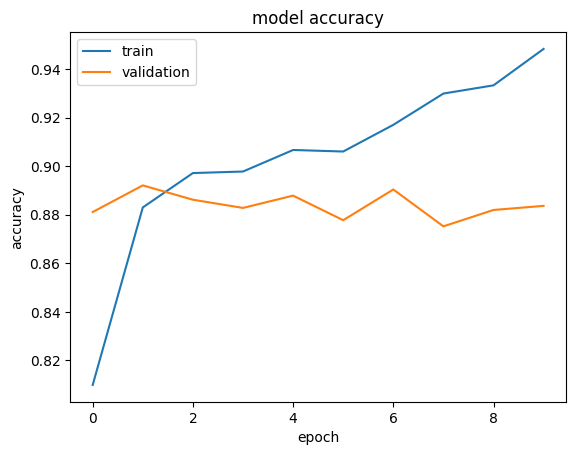

In [29]:
plt.figure(1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step


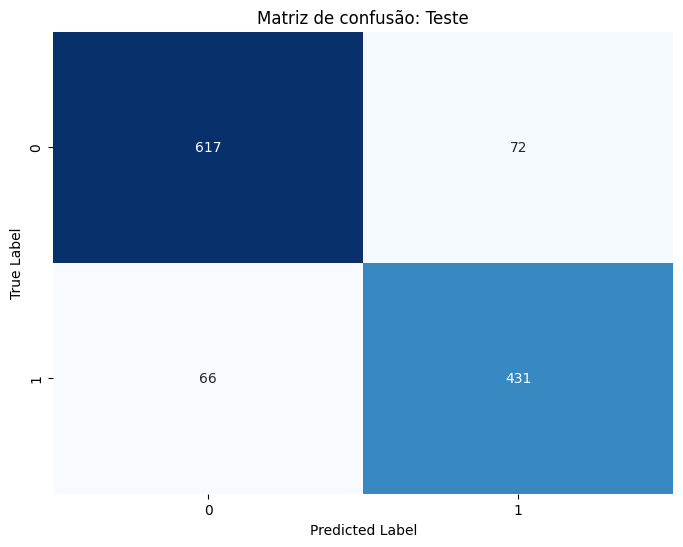

In [31]:
#Previsão do modelo
y_pred_te = model.predict(X_te_ind)

#Corte para previsão de classes 0 ou 1
y_pred_classes_te = (y_pred_te > 0.5).astype(int)

#Matriz de confusão
matriz_te = confusion_matrix(Y_te_ind, y_pred_classes_te)

#Visualizar a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de confusão: Teste')
plt.show()

148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step


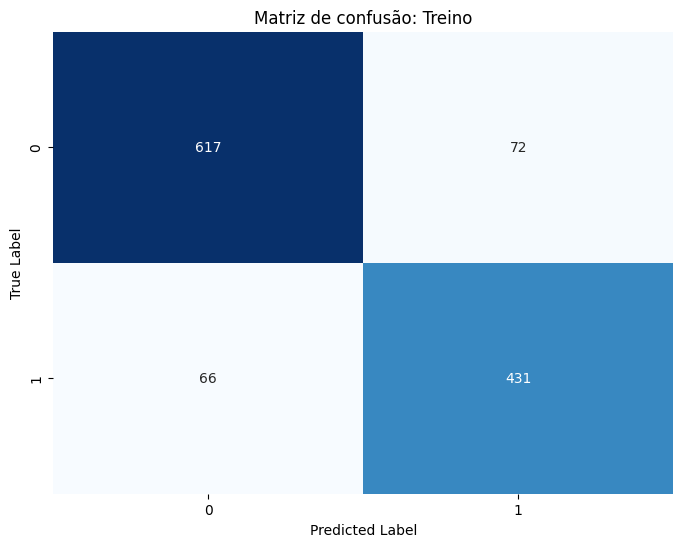

In [33]:
#Previsão do modelo
y_pred_tr = model.predict(X_tr_ind)

#Corte para previsão de classes 0 ou 1
y_pred_classes_tr = (y_pred_tr > 0.5).astype(int)

#Matriz de confusão
matriz_tr = confusion_matrix(Y_tr_ind, y_pred_classes_tr)

#Visualizar a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de confusão: Treino')
plt.show()